# Optical Music Recognition - PyTorch implementation

In this notebook I train a convolution neural network to be able to correctly identify the pitch of music notes. 

The dataset I am using was created by DeepScores, and is available at https://tuggeluk.github.io/downloads/.

In [24]:
# Import dependencies

import pandas as pd
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from pathlib import Path
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from random import randrange
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
import warnings

from google.colab import drive

os.chdir('//')
drive.mount('/content/gdrive', force_remount=True)
os.chdir('content/gdrive/MyDrive/OMR-project/')

from utils import collate_fn
import engine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive


## 1. Constructing data loaders

In [25]:
# Loading in DeepScores info 

train_df_DS = pd.read_csv('data/deep_scores_dense/train_names.csv', 
                       index_col=0, header = None)
test_df_DS = pd.read_csv('data/deep_scores_dense/test_names.csv', 
                      index_col=0, header = None)
classes_DS = pd.read_csv('data/deep_scores_dense/class_names.csv', 
                      index_col = 0, header = None)
class_map_decode_DS = classes_DS.to_dict()[1]
class_map_encode_DS = {v: k for k, v in class_map_decode_DS.items()}


# Loading in Vienna info
class_map_encode_V = {
    "a": 0, "h": 1,
      "c1": 2, "d1": 3,
      "e1": 4, "f1": 5,
      "g1": 6, "a1": 0,
      "h1": 1, "c2": 2,
      "d2": 3, "e2": 4,
      "f2": 5, "g2": 6,
      "a2": 0, "h2": 1,
      "c3": 2, "other": 7
        }

class_map_decode_V = {v: k for k, v in class_map_decode_DS.items()}

ROOT_V = 'data/originals-resized/'
all_ims_V = [file for file in os.listdir(ROOT_V) \
                          if os.path.isfile(ROOT_V + file) \
                          and file[0:4] == 'note']

train_fns_V, test_fns_V = train_test_split(all_ims_V, test_size = 0.15)
train_fns_V, val_fns_V = train_test_split(train_fns_V, test_size = 0.15)

In [26]:
class DeepScores(torch.utils.data.Dataset):
    
    def __init__(self, df):
        self.fns = df[1]
        self.ROOT = 'data/deep_scores_dense/'
    
    def __len__(self):
        return len(self.fns)
    
    def get_bboxes(self, fn, scale_factors):
        xml = ET.parse(f'{self.ROOT}xml_annotations/{fn}.xml')
        root = xml.getroot()
        elems = root.findall('object/bndbox')
        bboxes = []
        x_scale, y_scale = scale_factors        
        for e in elems:
            bbox = [float(b) for b in e.itertext()]
            # XML format is (x0, x1, y0, y1)
            # We need (x0, y0, x1, y1)
            x0y0x1y1 = [0, 2, 1, 3]
            bbox = ([bbox[i] for i in x0y0x1y1])

            '''bbox[0] = bbox[0] * x_scale - x_scale * 0.007
            bbox[1] = bbox[1] * y_scale - y_scale * 0.02
            bbox[2] = bbox[2] * x_scale + x_scale * 0.007
            bbox[3] = bbox[3] * y_scale + y_scale * 0.02'''

            bbox[0] = bbox[0] * x_scale
            bbox[1] = bbox[1] * y_scale
            bbox[2] = bbox[2] * x_scale
            bbox[3] = bbox[3] * y_scale 
            
            bboxes.append(bbox)
        return bboxes
    
    def get_labels(self, fn):
        xml = ET.parse(f'{self.ROOT}xml_annotations/{fn}.xml')
        root = xml.getroot()
        bbox_labels = []
        for tag in root.findall('object/name'):
            lab = tag.text
            lab = class_map_encode_DS[lab]
            bbox_labels.append(lab)
        return bbox_labels
    
    def get_bbox_area(self, bboxes):
        areas = [(x1 - x0) * (y1 - y0) for x0, y0, x1, y1 in bboxes]
        return areas

    def __getitem__(self, idx):
        file_name = self.fns[idx]
        fp = os.path.join(self.ROOT, 'images_png', file_name + '.png')
        img = cv2.imread(fp)
        img = img / 255.
        
        x_scale = 1000 
        y_scale = 1420 
        
        scale_factors = (x_scale, y_scale)
        
        img = cv2.resize(img, (x_scale, y_scale))
        img = torch.FloatTensor(img)

        # Change channels from (H, W, C) to (C, H, W)
        img = img.permute(2, 0, 1)
        
        bboxes = self.get_bboxes(file_name, scale_factors)
        bboxes = torch.as_tensor(bboxes)
        bboxes = bboxes.to(device)
        labels = torch.tensor(self.get_labels(file_name), dtype=torch.int64)
        area = torch.FloatTensor(self.get_bbox_area(bboxes))

        iscrowd = torch.zeros(len(labels), dtype=torch.int64)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # Copy to GPU if available
        img = img.to(device)
        area = area.to(device)
        iscrowd = iscrowd.to(device)
        labels = labels.to(device)

        return img, target


class ViennaSet(torch.utils.data.Dataset):
    
    def __init__(self, fns, root):
        self.ROOT = root
        self.file_list = fns
        self.class_map = class_map_encode_V # TODO make param  
      
    def __len__(self):
        return len(self.file_list)    
        
    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        
        fp = os.path.join(self.ROOT, file_name)
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        img = img / 255.
        
        attr = file_name.split('-')
        type_ = attr[0]
        time = attr[1]
        pitch = attr[2]

        im = torch.as_tensor(np.expand_dims(img, axis=0), dtype=torch.double)
        lab = self.class_map[pitch] 

        return im, lab 
  

In [27]:
params_DS = {'batch_size':4, 'collate_fn': collate_fn}
params_V = {'batch_size': 16, 'shuffle': True, 'num_workers': 0}

training_data_DS = DeepScores(train_df_DS)
training_data_generator_DS = torch.utils.data.DataLoader(training_data_DS, **params_DS)

test_data_DS = DeepScores(test_df_DS)
test_data_generator_DS = torch.utils.data.DataLoader(test_data_DS, **params_DS)

training_data_V  = ViennaSet(train_fns_V, ROOT_V)
train_generator_V = torch.utils.data.DataLoader(training_data_V, **params_V)

val_data_V = ViennaSet(val_fns_V, ROOT_V)
val_generator_V = torch.utils.data.DataLoader(val_data_V, **params_V)

test_data_V = ViennaSet(test_fns_V, ROOT_V)
test_generator_V = torch.utils.data.DataLoader(test_data_V)

In [19]:
# Use darknet

## 2. Basic EDA

### 2.1. DeepScores

First, lets plot one of the pages of music, and add the bounding boxes so we can check they align correctly.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


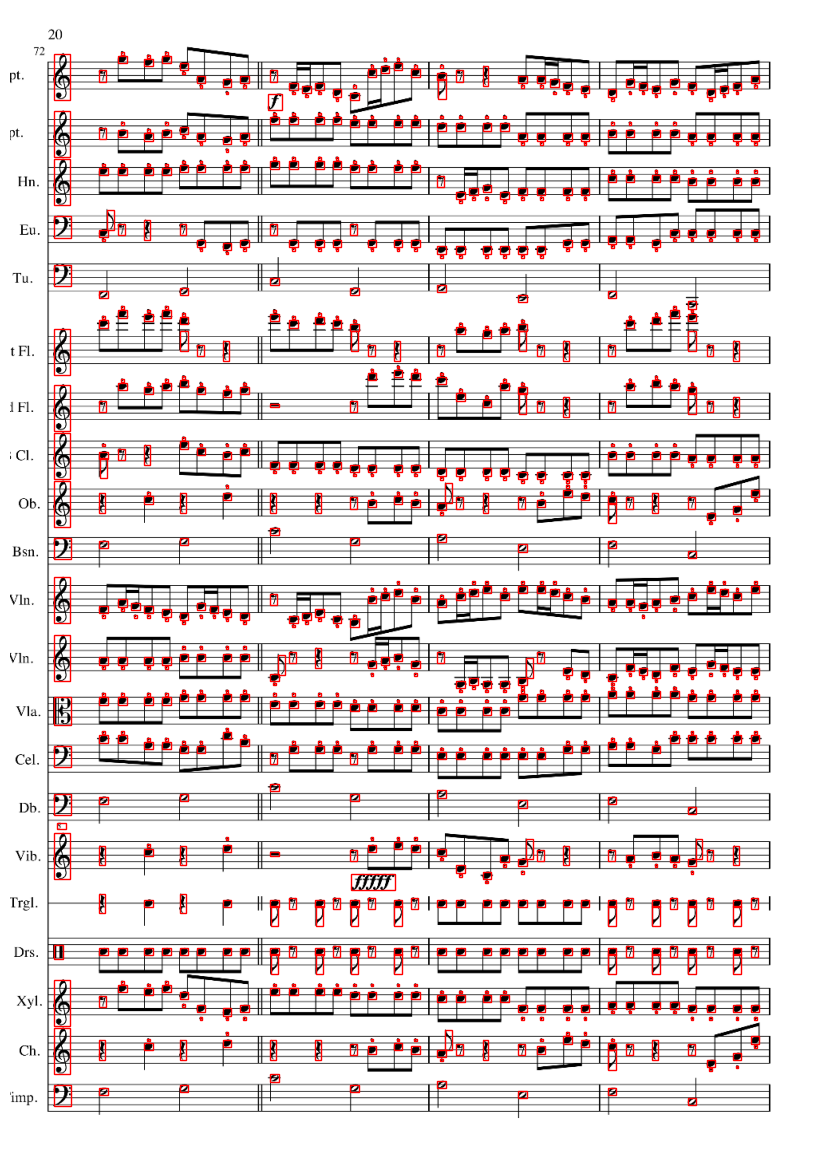

In [20]:
plt.figure(num=None, figsize=(20, 15), dpi=100, facecolor='w', edgecolor='k')
item = training_data_DS[200]
bboxes = list(item[1]['boxes'])
plt.imshow(item[0].to('cpu').permute(1, 2, 0))

for box in bboxes:
    x0, y0, x1, y1 = box.tolist()
    w = x1 - x0
    h = y1 - y0
    rect = Rectangle((x0, y0), w, h, fill=False, color='red')
    plt.axes().add_patch(rect)
plt.axis('off')  
plt.show()

We can see from the classes dataframe below, that the dataset only contains object class. We will therefore need to train a seperate classifier to recognise the pitch of each individual note;

In [21]:
# TODO try filtering on only note related labels

classes_DS[0:].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123
1,brace,repeatDot,segno,coda,gClef,cClefAlto,cClefTenor,fClef,unpitchedPercussionClef1,gClefChange,cClefAltoChange,cClefTenorChange,fClefChange,clef8,clef15,timeSig0,timeSig1,timeSig2,timeSig3,timeSig4,timeSig5,timeSig6,timeSig7,timeSig8,timeSig9,timeSig12,timeSig16,timeSigCommon,timeSigCutCommon,noteheadBlack,noteheadBlackSmall,noteheadHalf,noteheadHalfSmall,noteheadWhole,noteheadWholeSmall,noteheadDoubleWhole,noteheadDoubleWholeSmall,augmentationDot,flag8thUp,flag8thUpSmall,...,rest128th,restHBar,dynamicPiano,dynamicMezzo,dynamicForte,dynamicPPPPP,dynamicPPPP,dynamicPPP,dynamicPP,dynamicMP,dynamicMF,dynamicFF,dynamicFFF,dynamicFFFF,dynamicFFFFF,dynamicFortePiano,dynamicSforzando1,dynamicSforzato,dynamicRinforzando2,graceNoteAcciaccaturaStemUp,graceNoteAppoggiaturaStemUp,graceNoteAcciaccaturaStemDown,graceNoteAppoggiaturaStemDown,ornamentTrill,ornamentTurn,ornamentTurnInverted,ornamentMordent,stringsDownBow,stringsUpBow,arpeggiato,keyboardPedalPed,keyboardPedalUp,tuplet3,tuplet6,fingering0,fingering1,fingering2,fingering3,fingering4,fingering5


### 2.2. Vienna

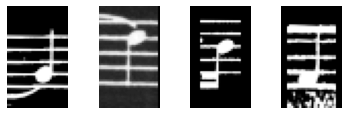

In [22]:
# Lets take a look at what a subset of the images look like
idxs = [randrange(training_data_V.__len__()) for i in range(4)]

for i, idx in enumerate(idxs):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(training_data_V.__getitem__(idx)[0].squeeze(), cmap = 'Greys')
    plt.subplots_adjust(wspace = 0.5)

## 3. Setting out a model pipeline

So, from the DeepScores dataset it seems we have access to the following information:

1. Large pages of music
2. Symbol class (e.g. note, rest, etc)
3. Bounding boxes

From other datasets such as the Vienna dataset we have access to single note pitch classifications. 

The pipeline will therefore be as follows:

*Training*

1. Train a Faster R-CNN model on the DeepScores dataset to recgonise objects on a page of music.
2. Expand bounding boxes around note objects to include contect
2. Train a single note classifier on the Vienna dataset to recognise note pitches.


*Inference* 

1. Pass a sheet of music through the object detector and stage 1 classifier (FR-CNN model). This will yield symbol types and bounding boxes for every symbol on the page.
2. Filter bounding boxes to remove those that do not relate to notes.
2. Crop images around bounding boxes and feed through single note classifier (SNC). 
3. Use results of the SNC to generate new GT labels.

![image](https://lilianweng.github.io/lil-log/assets/images/faster-RCNN.png)


## 4. Training the stage 1 object detection model

In [23]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model_1 = FasterRCNN(backbone, 
                   num_classes = 124, 
                   rpn_anchor_generator=anchor_generator, 
                   box_roi_pool = roi_pooler)


params = [p for p in model_1.parameters() if p.requires_grad]
optimiser = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser,
                                               step_size=3,
                                               gamma=0.1)

num_epochs = 10
model_1.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Se

In [ ]:
optimiser = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser,
                                               step_size=3,
                                               gamma=0.1)

for epoch in range(num_epochs):
    engine.train_one_epoch(model_1, 
                           optimiser, 
                           training_data_generator_DS, 
                           device, epoch,
                           print_freq=10)
    lr_scheduler.step()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model_1.state_dict(),
            'optimizer_state_dict': optimiser.state_dict()}, 
            f'ckpts/FRCNNstep{epoch}.pth')

## 5. Training the stage 2 single note classifier

### 5.1. Constructing the network

In [9]:
class ConvNetSingle(nn.Module):
    
    def __init__(self):
        super(ConvNetSingle, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, kernel_size = 5, out_channels = 3)
        self.conv2 = nn.Conv2d(in_channels = 3, kernel_size = 3, out_channels = 3)
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(792, 256)
        self.fc2 = nn.Linear(256, 8)
        self.fc3 = nn.Linear(16, 8)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

### 5.2. Training the network

In [ ]:
model_2 = ConvNetSingle()

optimiser = optim.Adam(model_2.parameters(), lr=0.001)
max_epochs = 10
log_int = 1

# Now for the training loop
for epoch in tqdm(range(max_epochs)):
    correct = 0
    total = 0
    correct_val = 0
    total_val = 0
    for local_batch, local_labels in train_generator_V:
        optimiser.zero_grad()
        pred = model_2(local_batch.float())
        loss = F.nll_loss(pred, local_labels)
        _, predicted = torch.max(pred.data, 1)
                
        total += local_labels.size(0)
        correct += (predicted == local_labels).sum().item()
        loss.backward()
        optimiser.step()
        
    with torch.no_grad():
            for local_batch, local_labels in val_generator_V:
                        optimiser.zero_grad()
                        pred = model_2(local_batch.float())
                        loss = F.nll_loss(pred, local_labels)
                        _, predicted = torch.max(pred.data, 1)
                        optimiser.step()
                        total_val += local_labels.size(0)
                        correct_val += (predicted == local_labels).sum().item()
    
    if (epoch % log_int) == 0:
        print(f'Epoch {epoch + 1} / {max_epochs}')
        print(f'Training accuracy = {round(correct/total, 4)}  \
        Validation accuracy = {round(correct_val/total_val, 4)} \n')

## 6. Inference

### 6.1. Generating object and bbox proposals



In [28]:
model_1.load_state_dict(torch.load('ckpts/FRCNNstep2.pth', map_location=torch.device('cpu'))['model_state_dict'])
model_1.eval()

# Single example
img = test_data_DS.__getitem__(12)[0]
pred = model_1.forward([img])

Plotting bbox predictions (pretty bad at the moment, more training needed and perhaps a different backbone. I will try out darknet52 next since that involves 8x upscaling which will be helpful for my small bboxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


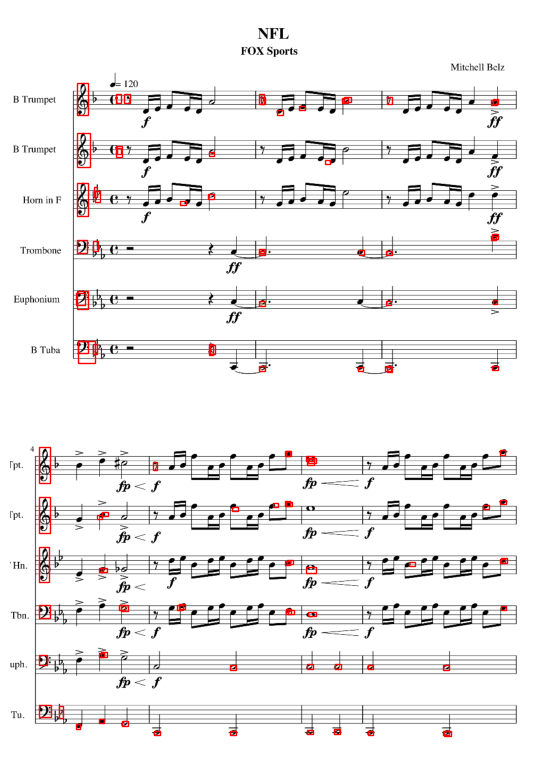

In [258]:
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
item = training_data_DS[500]
bboxes = pred[0]['boxes']
plt.imshow(test_data_DS[12][0].cpu().permute(1, 2, 0))

for box in bboxes:
    x0, y0, x1, y1 = box.tolist()
    w = x1 - x0
    h = y1 - y0
    rect = Rectangle((x0, y0), w, h, fill=False, color='red')
    plt.axes().add_patch(rect)

plt.axis('off')  
plt.show()

### 6.2. Crop to bbox

In this section I define a function that takes an image of a whole sheet of music, and crops it around a given bounding box. Because DeepScores bounding boxes are for every musical object, they tend to be very small around the notehead. To get around this issue, I will extend the bounding box by an arbitary amount to gather sufficient context for the single note classifier to make predictions.

These images are then padded and resized to 30x50.

In [253]:
def crop_to_bbox_and_pad(img, bbox):
  x0, y0, x1, y1 = bbox

  x0 = int(x0 * 0.98)
  x1 = int(x1 * 1.02)
  y0 = int(y0 * 0.96)
  y1 = int(y1 * 1.02)

  crop_img = img[:, y0:y1, x0:x1].permute(1, 2, 0)
  crop_img = np.array(crop_img)
  crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
  ht, wd = crop_img.shape

  ww = 60
  hh = 100
  color = 0
  result = np.full((hh, ww), color, dtype=np.uint8)

  # compute center offset
  xx = (ww - wd) // 2
  yy = (hh - ht) // 2

  # copy img image into center of result image
  result[yy:yy+ht, xx:xx+wd] = crop_img
  result = cv2.resize(result, (60, 100))
  return result

Lets now visualise what these cropped and padded images look like

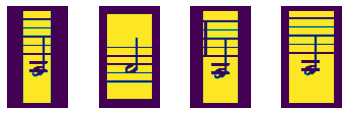

In [254]:
  idxs = [12, 16, 22, 28]
  
  for i, idx in enumerate(idxs):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')     
    plt.imshow(crop_to_bbox_and_pad(img, pred[0]['boxes'][idx]))
    plt.subplots_adjust(wspace = 0.5)


### 6.3. Single note classification [TODO]

In [ ]:
model_2.load_state_dict(torch.load('ckpts/covnet.pth'))

example_im = torch.as_tensor(crop_to_bbox_and_pad(img, pred[0]['boxes'][16]))
torch.argmax(model_2.forward(example_im.float()))

In [ ]:
iter(train_generator_V).next()[0].shape

### 6.4 Putting together the pieces [TODO]

In [235]:
torch.load('ckpts/FRCNNstep2.pth', map_location=torch.device('cpu'))['model_state_dict'].keys()